# Imports

In [284]:
import tweepy
import pandas as pd
import GetOldTweets3 as got
import datetime
import re
import unidecode
import nltk
from nltk import bigrams
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
import time
tweets_df = pd.read_csv('originalTweetsUntilDate.csv')
until_date = datetime.datetime(2020,11,14 ,0, 0)
tweets_df['Created_at'] = tweets_df['Created_at'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
tweets_df = tweets_df[tweets_df.Created_at <= until_date]
tweets_df

,Username,Created_at,Text
32,DelPatricia19,2020-11-13 20:55:28,Está na hora da decisão! Vamos nos unir para f...
33,DelPatricia19,2020-11-13 20:38:56,@irlanlira @RomarioOnze Agradecemos o apoio e ...
34,DelPatricia19,2020-11-13 20:37:57,@PaschoalSantos1 Vamos juntos fazer um Recife ...
35,DelPatricia19,2020-11-13 20:37:38,@Nino_Dangelo Vamos juntos!
36,DelPatricia19,2020-11-13 20:00:20,A mudança chegou e ela se chama Delegada Patrí...
...,...,...,...
2235,mendoncafilho,2020-09-28 15:33:48,"A verdade, para mim, significa confiança. É al..."
2236,mendoncafilho,2020-09-27 19:01:08,Eu queria saber de você: quais problemas na ci...
2237,mendoncafilho,2020-09-27 15:20:17,Mendonça consolida-se como ÚNICO da oposição q...
2238,mendoncafilho,2020-09-27 11:31:16,É vergonhosa a situação em que os Mercados Púb...


# Pre-processing data

In [285]:
nltk.download('rslp')
def Stemming(sentence):
    stemmer = nltk.stem.RSLPStemmer()
    phrase = []
    for word in sentence.split():
        #phrase.append(stemmer.stem(word))
        phrase.append(word)
    return phrase

[nltk_data] Error loading rslp: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [286]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('portuguese')) 

# To lower
tweets_df['Text'] = tweets_df.Text.apply(lambda t: t.lower())

# Unicode tweet (remove accents etc)
tweets_df['Text'] = tweets_df.Text.apply(lambda t: unidecode.unidecode(t))  

#Remove usernames 
tweets_df['Text'] = tweets_df.Text.apply(lambda t: re.sub('(@)[^\s]+','',t))

#Remove urls 
tweets_df['Text'] = tweets_df.Text.apply(lambda t: re.sub('(http)\S+', '', t, flags=re.MULTILINE))

#Remove new line 
tweets_df['Text'] = tweets_df.Text.apply(lambda t: t.replace('\n',''))

#Remove hashtags 
tweets_df['Text'] = tweets_df.Text.apply(lambda t: re.sub('(#)\w+','',t))

#Remove Numbers 
tweets_df['Text'] = tweets_df.Text.apply(lambda t: re.sub('(\d)+','',t))

#Remove special characteres 
tweets_df['Text'] = tweets_df.Text.apply(lambda t: re.sub(r"[^a-zA-Z0-9]+", ' ',t))

#Stemming and split text
tweets_df['Text'] = tweets_df.Text.apply(lambda t: Stemming(t))

#Remove stopwords
tweets_df['Text'] = tweets_df['Text'].apply(lambda t: [item for item in t if item not in stop_words])

#Remove rows without text
tweets_df = tweets_df[tweets_df['Text'].map(lambda l: len(l)) > 0]

#Generate biagrams 
tweets_df['Biagrams'] = tweets_df['Text'].apply(lambda t: list(bigrams(t)))
  
tweets_df.head(5)


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
<ipython-input-286-cde346d72b98>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['Biagrams'] = tweets_df['Text'].apply(lambda t: list(bigrams(t)))


,Username,Created_at,Text,Biagrams
32,DelPatricia19,2020-11-13 20:55:28,"[hora, decisao, vamos, unir, fazer, mudanca, r...","[(hora, decisao), (decisao, vamos), (vamos, un..."
33,DelPatricia19,2020-11-13 20:38:56,"[agradecemos, apoio, vamos, juntos, mudar, rec...","[(agradecemos, apoio), (apoio, vamos), (vamos,..."
34,DelPatricia19,2020-11-13 20:37:57,"[vamos, juntos, fazer, recife, melhor]","[(vamos, juntos), (juntos, fazer), (fazer, rec..."
35,DelPatricia19,2020-11-13 20:37:38,"[vamos, juntos]","[(vamos, juntos)]"
36,DelPatricia19,2020-11-13 20:00:20,"[mudanca, chegou, chama, delegada, patricia, d...","[(mudanca, chegou), (chegou, chama), (chama, d..."


# TF-IDI

In [287]:
def computeTFIDF(document):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(document)
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    return dense.tolist()

In [288]:
tweets_df['TFIDF'] = tweets_df['Text'].apply(lambda t: computeTFIDF(t))
tweets_df.head()

<ipython-input-288-034709219ecf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['TFIDF'] = tweets_df['Text'].apply(lambda t: computeTFIDF(t))


,Username,Created_at,Text,Biagrams,TFIDF
32,DelPatricia19,2020-11-13 20:55:28,"[hora, decisao, vamos, unir, fazer, mudanca, r...","[(hora, decisao), (decisao, vamos), (vamos, un...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
33,DelPatricia19,2020-11-13 20:38:56,"[agradecemos, apoio, vamos, juntos, mudar, rec...","[(agradecemos, apoio), (apoio, vamos), (vamos,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0...."
34,DelPatricia19,2020-11-13 20:37:57,"[vamos, juntos, fazer, recife, melhor]","[(vamos, juntos), (juntos, fazer), (fazer, rec...","[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0...."
35,DelPatricia19,2020-11-13 20:37:38,"[vamos, juntos]","[(vamos, juntos)]","[[0.0, 1.0], [1.0, 0.0]]"
36,DelPatricia19,2020-11-13 20:00:20,"[mudanca, chegou, chama, delegada, patricia, d...","[(mudanca, chegou), (chegou, chama), (chama, d...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,..."


# OpLexicon V3.0

In [289]:
dictionary = pd.read_csv('lexico_v3.0.txt', sep=",", header=None)
dictionary.columns = ['Word', 'Type', 'Polarity', 'Unknown']
dictionary

,Word,Type,Polarity,Unknown
0,=[,emot,-1,A
1,=@,emot,-1,A
2,=p,emot,-1,A
3,=P,emot,-1,A
4,=x,emot,-1,A
...,...,...,...,...
32186,zumbidores,adj,-1,A
32187,zumbir,vb,1,A
32188,zunir,vb,1,A
32189,zupar,vb,-1,A


# Apply stemming in the dictionary

In [290]:
stemmer = nltk.stem.RSLPStemmer()
#dictionary['Word'] = dictionary.Word.apply(lambda t: stemmer.stem(str(t)))
dictionary.drop_duplicates(inplace=True)
dictionary.set_index('Word',inplace=True)
dictionary

,Type,Polarity,Unknown
Word,,,
=[,emot,-1,A
=@,emot,-1,A
=p,emot,-1,A
=P,emot,-1,A
=x,emot,-1,A
...,...,...,...
zumbidores,adj,-1,A
zumbir,vb,1,A
zunir,vb,1,A


# Polarity Equation

In [291]:
def polarity(tweet):
    posity_words = 0
    negative_words = 0
    for word in tweet:
        if word in dictionary.index:
            if dictionary.loc[word].Polarity.shape == ():
                if dictionary.loc[word].Polarity == 1:
                    posity_words+=1
                elif dictionary.loc[word].Polarity == -1:
                    negative_words+=1
            else:
                currentPolarity = dictionary.loc[word].Polarity[0]
                for polarity in dictionary.loc[word].Polarity:
                    if(polarity != currentPolarity):
                        break
                if dictionary.loc[word].Polarity[0] == 1:
                    posity_words+=1
                elif dictionary.loc[word].Polarity[0] == -1:
                    negative_words+=1
                
    result = posity_words - negative_words
    return result   

In [292]:
tweets_df['Polarity'] = tweets_df['Text'].apply(lambda t: polarity(t))
tweets_df

<ipython-input-292-a26ce512ccee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['Polarity'] = tweets_df['Text'].apply(lambda t: polarity(t))


,Username,Created_at,Text,Biagrams,TFIDF,Polarity
32,DelPatricia19,2020-11-13 20:55:28,"[hora, decisao, vamos, unir, fazer, mudanca, r...","[(hora, decisao), (decisao, vamos), (vamos, un...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
33,DelPatricia19,2020-11-13 20:38:56,"[agradecemos, apoio, vamos, juntos, mudar, rec...","[(agradecemos, apoio), (apoio, vamos), (vamos,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0....",-1
34,DelPatricia19,2020-11-13 20:37:57,"[vamos, juntos, fazer, recife, melhor]","[(vamos, juntos), (juntos, fazer), (fazer, rec...","[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0....",1
35,DelPatricia19,2020-11-13 20:37:38,"[vamos, juntos]","[(vamos, juntos)]","[[0.0, 1.0], [1.0, 0.0]]",0
36,DelPatricia19,2020-11-13 20:00:20,"[mudanca, chegou, chama, delegada, patricia, d...","[(mudanca, chegou), (chegou, chama), (chama, d...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",-1
...,...,...,...,...,...,...
2235,mendoncafilho,2020-09-28 15:33:48,"[verdade, mim, significa, confianca, algo, car...","[(verdade, mim), (mim, significa), (significa,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]...",0
2236,mendoncafilho,2020-09-27 19:01:08,"[queria, saber, voce, quais, problemas, cidade...","[(queria, saber), (saber, voce), (voce, quais)...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0
2237,mendoncafilho,2020-09-27 15:20:17,"[mendonca, consolida, unico, oposicao, pode, f...","[(mendonca, consolida), (consolida, unico), (u...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0
2238,mendoncafilho,2020-09-27 11:31:16,"[vergonhosa, situacao, mercados, publicos, rec...","[(vergonhosa, situacao), (situacao, mercados),...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]...",-1


# Delegada Patricia tweets

In [293]:
def customDataFrame(df):
    result = []
    positive = 0
    negative = 0
    for date in df.index.unique():
        if isinstance(df.loc[date].Polarity, (int, np.integer)):
            polarity = df.loc[date].Polarity
            if polarity > 0:
                positive+=polarity
            else:
                negative+=polarity
        else:
            for polarity in df.loc[date].Polarity:
                if polarity > 0:
                    positive+=polarity
                else:
                    negative+=polarity
        result.append([date,positive,negative])
        positive = 0
        negative = 0
    result_df = pd.DataFrame(result,columns = ['date','positive','negative'])
    return result_df
        
                
        

In [295]:
delPatricia_tweets = tweets_df[tweets_df['Username'] == 'DelPatricia19']
#delPatricia_tweets['Created_at'] = delPatricia_tweets['Created_at'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
delPatricia_tweets['Created_at'] = delPatricia_tweets['Created_at'].apply(lambda d: d.date())
delPatricia_tweets.set_index('Created_at',inplace=True)
delPatricia_polarity = customDataFrame(delPatricia_tweets)


<ipython-input-295-65608e5d9dfc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delPatricia_tweets['Created_at'] = delPatricia_tweets['Created_at'].apply(lambda d: d.date())


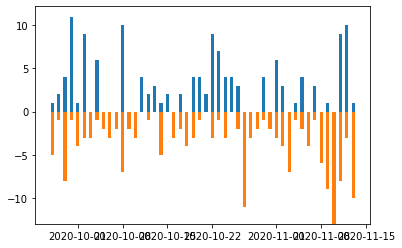

In [296]:
fig, ax = plt.subplots()
width = 0.50 
p1 = plt.bar(delPatricia_polarity.date,delPatricia_polarity.positive, width, bottom=delPatricia_polarity.negative)
p2 = plt.bar(delPatricia_polarity.date,delPatricia_polarity.negative, width)
#ax.plot(delPatricia_polarity.date,delPatricia_polarity.positive,Color='g')
#ax.plot(delPatricia_polarity.date,delPatricia_polarity.negative,Color='r')
plt.show()

# João Campos tweets

In [297]:
joaoCampos_tweets = tweets_df[tweets_df['Username'] == 'JoaoCampos']
#joaoCampos_tweets['Created_at'] = joaoCampos_tweets['Created_at'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
joaoCampos_tweets['Created_at'] = joaoCampos_tweets['Created_at'].apply(lambda d: d.date())
joaoCampos_tweets.set_index('Created_at',inplace=True)
joaoCampos_polarity = customDataFrame(joaoCampos_tweets)

<ipython-input-297-e435d0d51016>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joaoCampos_tweets['Created_at'] = joaoCampos_tweets['Created_at'].apply(lambda d: d.date())


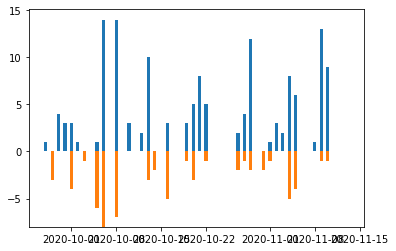

In [298]:
fig, ax = plt.subplots()
width = 0.50 
p1 = plt.bar(joaoCampos_polarity.date,joaoCampos_polarity.positive, width, bottom=joaoCampos_polarity.negative)
p2 = plt.bar(joaoCampos_polarity.date,joaoCampos_polarity.negative, width)
plt.show()

# Marilia Arraes Tweets

In [299]:
mariliaArraes_tweets = tweets_df[tweets_df['Username'] == 'MariliaArraes']
#mariliaArraes_tweets['Created_at'] = mariliaArraes_tweets['Created_at'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
mariliaArraes_tweets['Created_at'] = mariliaArraes_tweets['Created_at'].apply(lambda d: d.date())
mariliaArraes_tweets.set_index('Created_at',inplace=True)
mariliaArraes_polarity = customDataFrame(mariliaArraes_tweets)

<ipython-input-299-f9b8f29186ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mariliaArraes_tweets['Created_at'] = mariliaArraes_tweets['Created_at'].apply(lambda d: d.date())


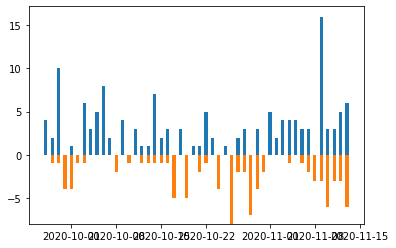

In [300]:
fig, ax = plt.subplots()
width = 0.50 
p1 = plt.bar(mariliaArraes_polarity.date,mariliaArraes_polarity.positive, width, bottom=mariliaArraes_polarity.negative)
p2 = plt.bar(mariliaArraes_polarity.date,mariliaArraes_polarity.negative, width)
plt.show()

# Mendonça Filho tweets

In [301]:
mendoncafilho_tweets = tweets_df[tweets_df['Username'] == 'mendoncafilho']
#mendoncafilho_tweets['Created_at'] = mendoncafilho_tweets['Created_at'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
mendoncafilho_tweets['Created_at'] = mendoncafilho_tweets['Created_at'].apply(lambda d: d.date())
mendoncafilho_tweets.set_index('Created_at',inplace=True)
mendoncafilho_polarity = customDataFrame(mendoncafilho_tweets)

<ipython-input-301-0a89952c1bef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mendoncafilho_tweets['Created_at'] = mendoncafilho_tweets['Created_at'].apply(lambda d: d.date())


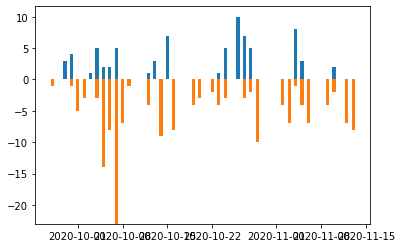

In [302]:
fig, ax = plt.subplots()
width = 0.50 
p1 = plt.bar(mendoncafilho_polarity.date,mendoncafilho_polarity.positive, width, bottom=mendoncafilho_polarity.negative)
p2 = plt.bar(mendoncafilho_polarity.date,mendoncafilho_polarity.negative, width)
plt.show()